In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

SUBSET_LEN = 11
DPI = 80
FIGSIZE, FIGSIZE_LONG = (10, 6), (12, 6)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('axes', labelsize=20)

In [3]:
wind_df = pd.read_csv("wind.csv", index_col=0)
sea_df = pd.read_csv("sla.csv", index_col=0)

In [4]:
coordinates = wind_df.index
dates = wind_df.columns

Для трех значений параметра $v_{min}$ — минимальной скорости штормового ветра — рассмотрим разницу между средними значениями аномалий уровня моря и скорости ветра в заданных точках.

In [15]:
storm_wind_speed = 15 # [10 / 1.5, 10, 10 * 1.5]
storms = []
for i in range(len(coordinates)):
    index = coordinates[i]
    
    j = 0
    while j + SUBSET_LEN < len(dates):
        if wind_df.iloc[i, j] < storm_wind_speed: # нет шторма
            j += 1
        else: # шторм, смотрим
            count_storm, count_calm = 0, 0
            for shift in range(SUBSET_LEN):
                if not np.isnan(sea_df.iloc[i, j + shift]):
                    count_storm += (wind_df.iloc[i, j + shift] >= storm_wind_speed)
                    count_calm += (wind_df.iloc[i, j + shift] < storm_wind_speed)
            
            if count_storm >= 4 and count_calm >= 4 and count_storm + count_calm == SUBSET_LEN:
                storms.append([count_storm, count_calm, i, j]) # начало шторма
            j += SUBSET_LEN
print(len(storms))

66235


In [16]:
N_subsets = len(storms)
source_rows_list = []
for index in range(N_subsets):
    i, j = storms[index][2], storms[index][3]
    count_storm = storms[index][0] # количество штормовых дней
    count_calm = storms[index][1] # количество спокойных дней
    storm_coordinates = wind_df.index[i] # координаты шторма
    storm_date = wind_df.columns[j] # дата начала шторма
    
    storm_sea, calm_sea = [], []
    for shift in range(SUBSET_LEN):
        cur_sla = sea_df.iloc[i, j + shift]
        cur_wind = wind_df.iloc[i, j + shift]
        if cur_wind >= storm_wind_speed:
            storm_sea.append(cur_sla)
        else:
            calm_sea.append(cur_sla)
    
    mean_storm_sla = np.mean(storm_sea)
    mean_calm_sla = np.mean(calm_sea)
    row_df = [storm_date, storm_coordinates, count_storm, count_calm, 
              mean_storm_sla, mean_calm_sla, mean_storm_sla - mean_calm_sla]
    source_rows_list.append(row_df)

source_subsets_df = pd.DataFrame(source_rows_list, 
        columns=["start_date", "coordinates", "count_storm", "count_calm", "sla_storm", "sla_calm", "sla_diff"])
sla_diff = source_subsets_df.sla_diff.to_numpy()

In [17]:
source_subsets_df

,start_date,coordinates,count_storm,count_calm,sla_storm,sla_calm,sla_diff
0,2008-12-17,"(35.625, 69.52166)",4,7,0.115352,0.093665,0.021687
1,2010-10-23,"(35.625, 69.52166)",4,7,-0.001353,-0.008632,0.007279
2,1992-10-12,"(337.5, 69.52166)",4,7,-0.032397,-0.028291,-0.004106
3,1993-03-06,"(337.5, 69.52166)",5,6,-0.083306,-0.076665,-0.006641
4,1996-09-16,"(337.5, 69.52166)",4,7,0.042239,0.051150,-0.008911
...,...,...,...,...,...,...,...
66230,2016-01-25,"(240.0, -73.33066)",4,7,0.034124,0.033237,0.000886
66231,2016-01-25,"(241.875, -73.33066)",4,7,-0.009632,0.012157,-0.021789
66232,2016-01-25,"(243.75, -73.33066)",4,7,0.007670,0.004846,0.002825
66233,2016-01-25,"(245.625, -73.33066)",4,7,-0.016580,-0.033110,0.016530


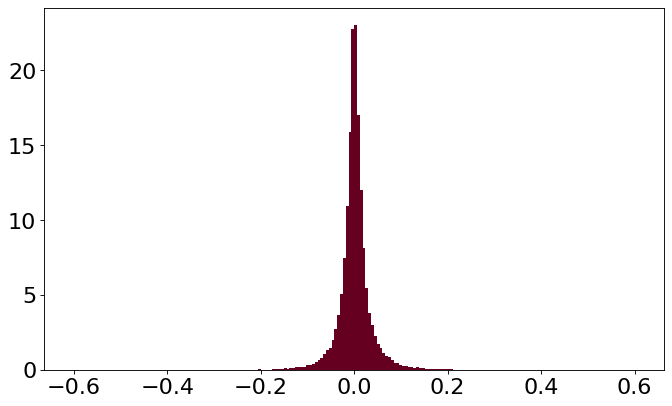

In [18]:
fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
abs_max = abs(sla_diff).max()
(y, bins, batches) = plt.hist(sla_diff, bins=200, density=True, range=(-abs_max, abs_max), color="xkcd:maroon")
x = np.array([(bins[i + 1] + bins[i]) / 2 for i in range(len(bins) - 1)])

Распределение полученной величины ($\Delta sla$) вблизи нуля выглядит следующим образом:

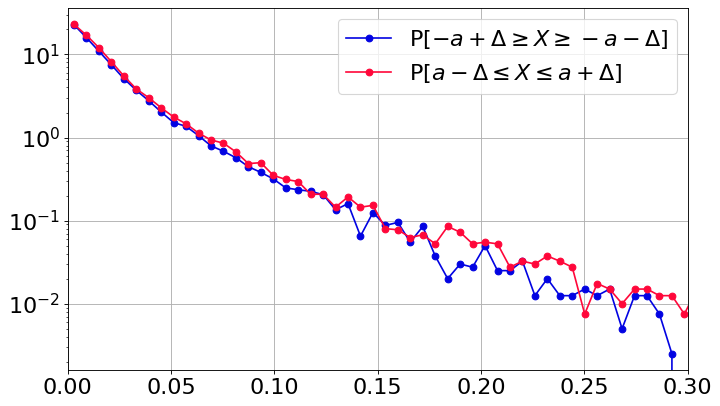

In [19]:
fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.grid(True)
plt.yscale('log')
plt.plot(-x[x < 0], y[x < 0], '-o', 
         color="xkcd:pure blue", label="P[$-a + \Delta \geq X \geq -a - \Delta$]")
plt.plot(x[x >= 0], y[x >= 0], '-o', 
         color="xkcd:neon red", label="P[$a - \Delta \leq X \leq a + \Delta$]")
plt.xlim((0.0, 0.3))
plt.legend(loc="best")
plt.show()
fig.savefig("sla_log_hist_{}.pdf".format(storm_wind_speed))

Площадь под красным графиков больше соответствующей площади под синим графиком, следовательно, положительные значения $\Delta sla$ встречаются немного чаще симметричных отрицательных.

Для того, чтобы оценить статистическую значимость найденного эффекта, сгенерируем набор сдвинутых во времени выборок, после чего 1000 раз найдем аналогичную разницу в рандомизированном разбиение сдвинутых выборок на штормовые и спокойные дни.

In [36]:
fraq_4_7 = len(source_subsets_df[(source_subsets_df.count_storm == 4) & (source_subsets_df.count_calm == 7)])
fraq_5_6 = len(source_subsets_df[(source_subsets_df.count_storm == 5) & (source_subsets_df.count_calm == 6)])
fraq_6_5 = len(source_subsets_df[(source_subsets_df.count_storm == 6) & (source_subsets_df.count_calm == 5)])
fraq_7_4 = len(source_subsets_df[(source_subsets_df.count_storm == 7) & (source_subsets_df.count_calm == 4)])

p1 = fraq_4_7 / N_subsets # вероятность распределение дней как (4, 7)
p2 = fraq_5_6 / N_subsets # вероятность распределение дней как (5, 6)
p3 = fraq_6_5 / N_subsets # вероятность распределение дней как (6, 5)
p4 = fraq_7_4 / N_subsets # вероятность распределение дней как (7, 4)

storm_days_cnt = np.array([4, 5, 6, 7])
storm_days_proba = np.array([p1, p2, p3, p4]) 

print(storm_wind_speed, fraq_4_7, fraq_5_6, fraq_6_5, fraq_7_4, N_subsets)
(fraq_4_7 + fraq_5_6 + fraq_6_5 + fraq_7_4) == N_subsets

10 134188 126240 115384 96575 472387


True

In [13]:
def getRandomSubsetsDataframe(coordinates, dates, shift_days=6, shift_coordinates=0):
    random_rows_list = []
    for index in range(N_subsets):
        if index % 50000 == 0:
            print(index)
        i, j = storms[index][2], storms[index][3]
        if i + shift_coordinates >= len(coordinates) or j + shift_days + SUBSET_LEN > len(dates):
            continue
        k = 0
        while k < SUBSET_LEN and not np.isnan(sea_df.iloc[i + shift_coordinates, j + shift_days + k]):
            k += 1
        if k < SUBSET_LEN:
            continue
            
        random_rows_list.append([i + shift_coordinates, j + shift_days])
    return pd.DataFrame(random_rows_list, columns=["coordinates_index", "start_date_index"])

random_subsets_df = getRandomSubsetsDataframe(coordinates, dates)

0
50000


In [14]:
def getMeanSlaDifference(index):
    i, j = random_subsets_df.iloc[index, 0], random_subsets_df.iloc[index, 1] # уже сдвинуты
    count_storm = random.choices(storm_days_cnt, storm_days_proba)[0] # count_calm = 11 - count_storm 

    random_storms = np.random.choice(np.arange(subset_len), count_storm, replace=False)
    random_storms_indexes = np.zeros(SUBSET_LEN, dtype=bool)
    random_storms_indexes[random_storms] = True

    mean_storm_sla = sea_df.iloc[i, j:j + subset_len][random_storms_indexes].mean()
    mean_calm_sla = sea_df.iloc[i, j:j + subset_len][~random_storms_indexes].mean()
    return mean_storm_sla - mean_calm_sla

meanSlaDiff = np.vectorize(getMeanSlaDifference)

In [15]:
def getProbabilityDifference(values, a_array): # P[X >= a] - P[X <= -a]
    return np.array([((values >= a).sum() - (values <= -a).sum()) / values.size for a in a_array])

def getExpectationDifference(values, cur_a, delta): # P[a < X < a + delta] - P[-a - delta < X < -a]
    p_plus_a = ((values >= cur_a) & (values <= cur_a + delta)).sum() / values.size
    p_minus_a =((values >= -cur_a - delta) & (values <= -cur_a)).sum() / values.size
    return p_plus_a - p_minus_a

def findExpectation(values, a): # sum_{a} a_i \cdot \Delta p(a)
    expectation = 0.0
    for i in range(len(a) - 1):
        expectation += a[i] * getExpectationDifference(values, a[i], a[i + 1] - a[i])
    return expectation

In [ ]:
from concurrent.futures import ProcessPoolExecutor

tests_number = 1000
random_sla_diff = []
def test(i):
    cur_sla_diff = meanSlaDiff(random_subsets_df.index)
    return (i, cur_sla_diff)

futures = []
with ProcessPoolExecutor(max_workers=10) as executor:
    futures = executor.map(test, range(tests_number))

    for x in futures:
        print(x[0])
        random_sla_diff.append(x[1]) # sla_diff для i-го теста

In [19]:
random_sla_file = open("random_sla_diff_{}.txt".format(storm_wind_speed), "w")
for i in range(tests_number):
    print(" ".join(map(str, random_sla_diff[i])), file=random_sla_file)
random_sla_file.close()
random_sla_diff = np.array(random_sla_diff) # shape  = (tests_number, N_subsets)

In [16]:
tests_number = 1000
random_sla_file = open("random_sla_diff_{}.txt".format(storm_wind_speed), "r")
random_sla_diff = []
for line in random_sla_file:
    random_sla_diff.append(list(map(float, line.split())))
    if len(random_sla_diff) % 100 == 0:
        print(len(random_sla_diff))
random_sla_file.close()
random_sla_diff = np.array(random_sla_diff) # shape = (tests_number, N_subsets)

100
200
300
400
500
600
700
800
900
1000


In [17]:
start_a = dict({6.7: 0.05, 10: 0.015, 15: 0.0}) # [start_a, 0.5] с шагом 0.005
a = np.arange(start_a[storm_wind_speed], 0.5001, 0.005)

In [18]:
random_expectations = []
for i in range(tests_number):
    random_expectations.append(findExpectation(random_sla_diff[i], a))

In [19]:
random_proba_difference = []
for i in range(tests_number):
    random_proba_difference.append(getProbabilityDifference(random_sla_diff[i], a))
random_proba_difference = np.array(random_proba_difference) # shape = (tests_number, a.size)

In [20]:
need_percentile = 99
need_index = 990
random_proba_endvalues = [np.percentile(random_proba_difference[:,i], need_percentile) for i in range(len(a))]
real_proba_difference = getProbabilityDifference(sla_diff, a)
test = random_expectations.index(sorted(random_expectations)[need_index])

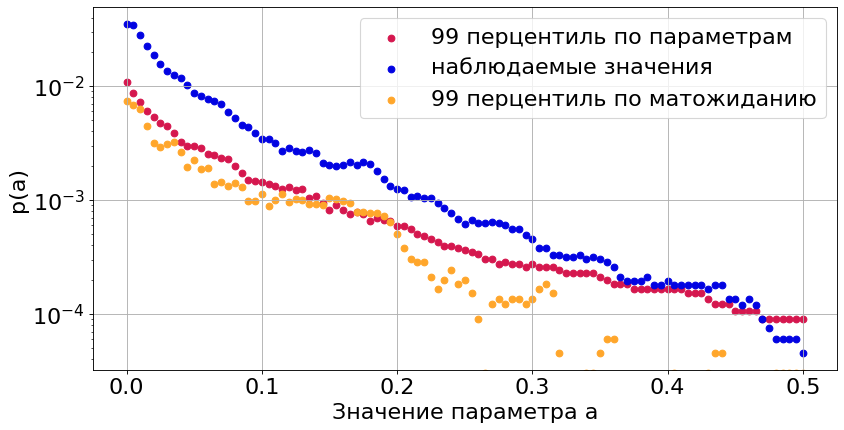

In [21]:
fig = plt.figure(dpi=DPI, figsize=FIGSIZE_LONG)
plt.xlabel("Значение параметра a")
plt.ylabel("p(a)")
plt.scatter(a, random_proba_endvalues, color="xkcd:lipstick", label="99 перцентиль по параметрам")
plt.scatter(a, real_proba_difference, color="xkcd:pure blue", label="наблюдаемые значения")
plt.scatter(a, random_proba_difference[test], color="xkcd:mango", label="99 перцентиль по матожиданию")
plt.grid(True)
plt.yscale("log")
plt.legend(loc="best")
plt.show()
fig.savefig("random_tests_log_{}.pdf".format(storm_wind_speed))

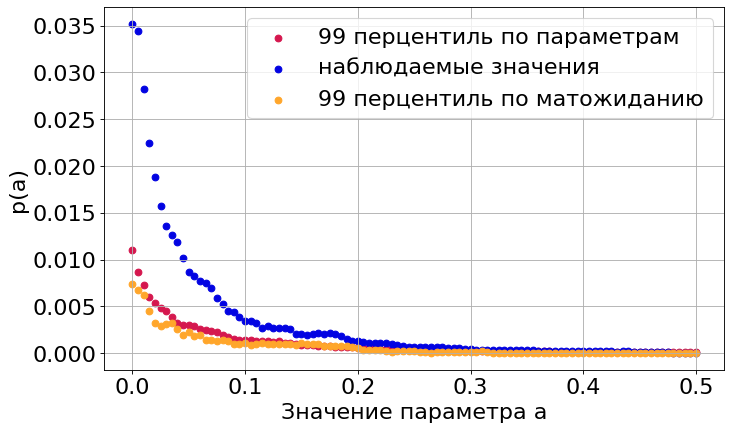

In [22]:
fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.xlabel("Значение параметра a")
plt.ylabel("p(a)")
plt.scatter(a, random_proba_endvalues, color="xkcd:lipstick", label="99 перцентиль по параметрам")
plt.scatter(a, real_proba_difference, color="xkcd:pure blue", label="наблюдаемые значения")
plt.scatter(a, random_proba_difference[test], color="xkcd:mango", label="99 перцентиль по матожиданию")
plt.grid(True)
plt.legend(loc="best")
plt.show()
fig.savefig("random_tests_{}.pdf".format(storm_wind_speed))

Таким образом, реальные наблюдаемые значения оказываются заметно больше даже крайних значений, полученных в результате статистического тестирования. Следовательно, можно говорить о статистической значимости найденного эффекта.